In [11]:
#BALL TRACKING WITH COLORS FOR ONE FRAME. Experimentation

In [12]:
# import the necessary packages
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
from skimage.morphology import erosion, dilation, opening, closing
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from PIL import Image
from IPython.display import Image as IPImage, display


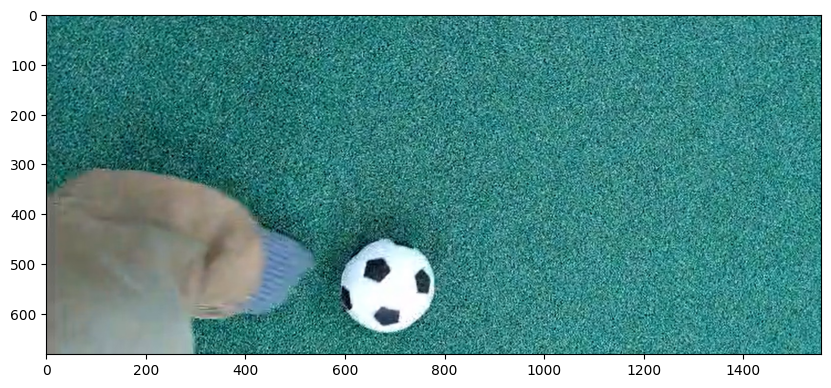

In [13]:
#NOT IN USE: define the lower and upper boundaries of the black, gray and white
#black_hsv = (0, 0, 0) #black
#white_hsv = (360, 0, 255) #white
#yellowish_hsv = (60, 30, 255)  # slightly yellowish


image_path = 'frame_pant.jpg' 
frame = cv2.imread(image_path)


#Visualize function
def visualize(image, gray = False, hsv_rep = False):
    plt.figure(figsize=(10, 5))

    if hsv_rep and not gray:
        image = hsv_to_rgb(np.array(image) / np.array([180, 255, 255]))
        plt.imshow(image) 

    elif not hsv_rep and gray:
        plt.imshow(image, cmap='gray')

    else:
        plt.imshow(image) 

    plt.show()

visualize(frame)

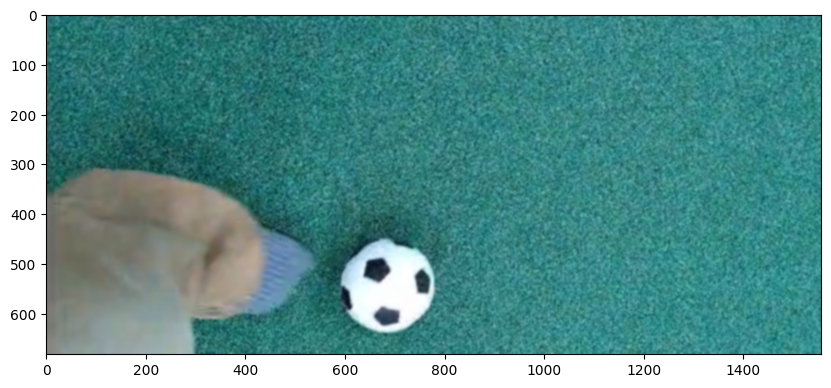

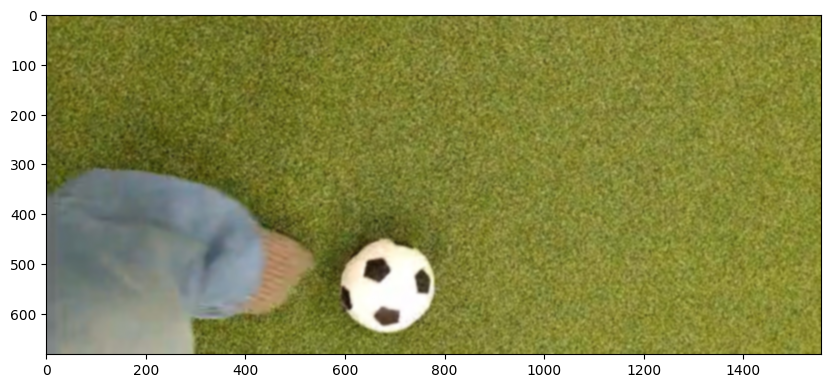

In [14]:
#frame = cv2.resize(frame, (600, 400))
blurred = cv2.GaussianBlur(frame, (11, 11), 0)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

visualize(blurred)
visualize(hsv, hsv_rep = True)

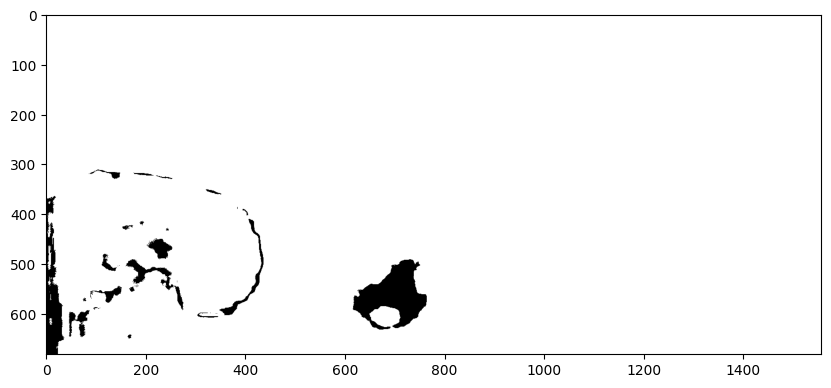

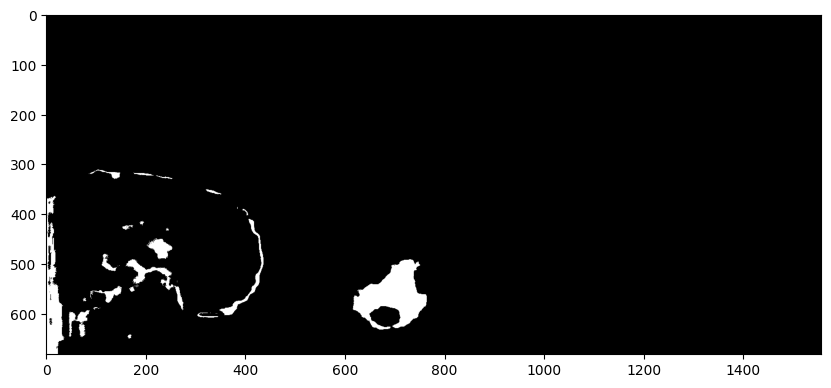

In [15]:
# To select black, white and gray values it chooses values with a low saturation
threshold_value = 15
_, mask_inv = cv2.threshold(hsv[:, :, 1], threshold_value, 255, cv2.THRESH_BINARY)

visualize(mask_inv, gray=True)
mask = cv2.bitwise_not(mask_inv)
visualize(mask, gray=True)


In [16]:
#POSSIBLE TUNNING FOR THE FUTURE

    #yellowish_mask = cv2.inRange(hsv, (0, 0, 0), yellowish_hsv)

# Combine the masks to get the final mask
    #final_mask = cv2.bitwise_or(mask, yellowish_mask)


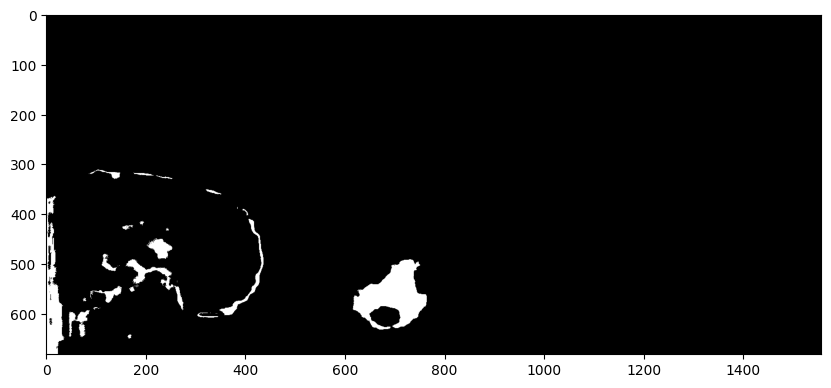

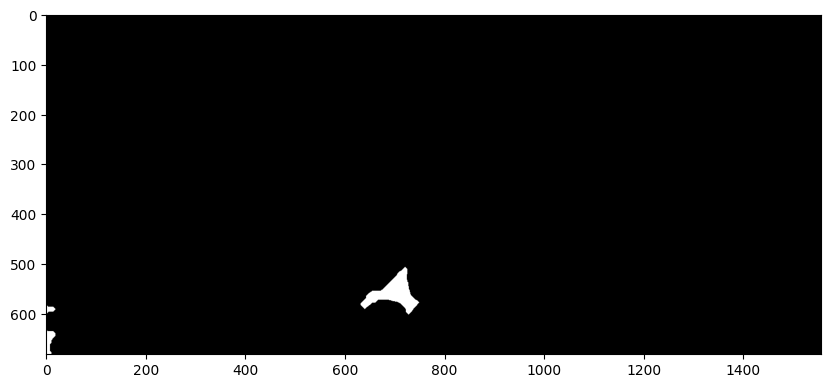

In [17]:
# An alternative i want to try:
def multi_erosion(img, selem, n):
    """Do a successive erosion on the same image by N times."""
    img = cv2.erode(img, selem, iterations=n)
    return img


def multi_dilation(img, selem, n):
    """Do a successive dilation on the same image by N times."""
    img = cv2.dilate(img, selem, iterations=n)
    return img

m = 1
m1 = 1
m2 = 1
m3 = 1
m4 = 1
selem_hor = np.array([[0, 0, 0],
                      [m, m, m],
                      [0, 0, 0]], dtype=np.uint8)

selem_ver = np.array([[0, m1, 0],
                      [0, m1, 0],
                      [0, m1, 0]], dtype=np.uint8)

selem_diag = np.array([[m3, 0, 0],
                      [0, m3, 0],
                      [0, 0, m3]], dtype=np.uint8)


selem_diag2 = np.array([[0, 0, m4],
                      [0, m4, 0],
                      [m4, 0, 0]], dtype=np.uint8)

selem_cir = np.array([[0, 0, m2, 0, 0],
                      [0, m2, m2, m2, 0],
                      [m2, m2, m2, m2, m2],
                      [0, m2, m2, m2, 0],
                      [0, 0, m2, 0, 0]], dtype=np.uint8)

# Morphological Operations
art1_new = multi_erosion(mask, selem_hor.astype(np.uint8), 5)
#art1_new = multi_dilation(art1_new, selem_cir.astype(np.uint8), 1)
art1_new = multi_erosion(art1_new, selem_ver.astype(np.uint8), 5)
art1_new = multi_erosion(art1_new, selem_diag.astype(np.uint8), 5)
art1_new = multi_erosion(art1_new, selem_diag2.astype(np.uint8), 5)
art1_new = multi_erosion(art1_new, selem_cir.astype(np.uint8), 1)
art1_new = multi_dilation(art1_new, selem_cir.astype(np.uint8), 2)
art1_new = np.where(art1_new != 0, 1, 0)

visualize(mask, gray=True)
visualize(art1_new, gray=True)



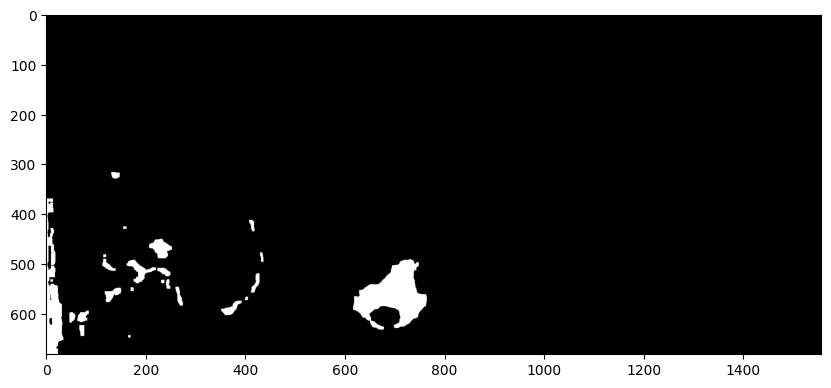

In [18]:
#This is what the dude did
mask1 = cv2.erode(mask, None, iterations=2)
mask2 = cv2.dilate(mask1, None, iterations=2)

visualize(mask2, gray = True)

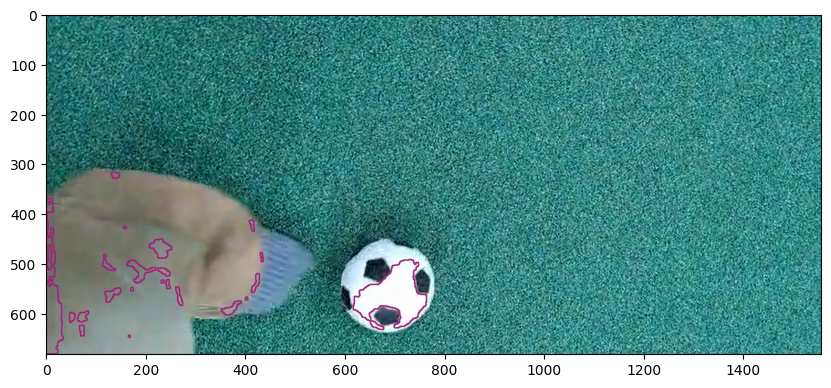

In [19]:
# find contours in the mask and initialize the current
# (x, y) center of the ball
mask = mask2
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
center = None

for c in cnts:
    cv2.drawContours(frame, [c], -1, (160, 34, 119), 2)

visualize(frame)

10393.5


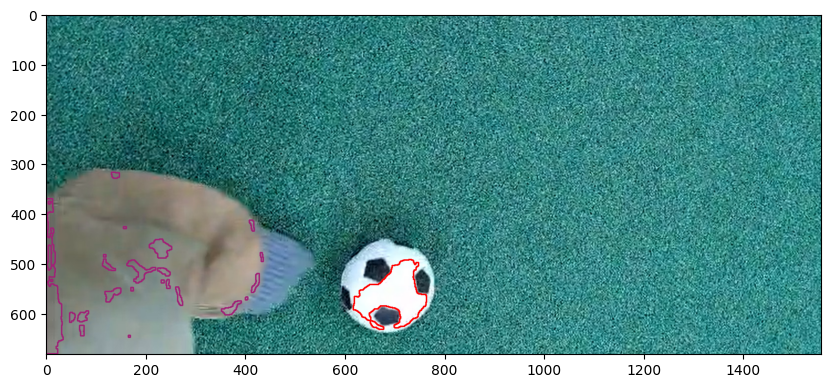

In [20]:
circles = []
for contour in cnts:
			area = cv2.contourArea(contour)
			perimeter = cv2.arcLength(contour, True)
			if int(perimeter) != 0 and area > 1050: # Perimeter to avoid divide by 0, and area so it doesn't choose small circles
				circularity = 4 * np.pi * area / (perimeter * perimeter)
				circles.append((contour, circularity))


# Choose the contour with the highest circularity
circles.sort(key=lambda x: abs(x[1] - 1))  # Sort by circularity closest to 1
best_circle = circles[0][0]  # Select the contour with closest circularity to 1
print(cv2.contourArea(best_circle))
# Draw the chosen contour
cv2.drawContours(frame, [best_circle], -1, (255, 0, 0), 2)
visualize(frame)

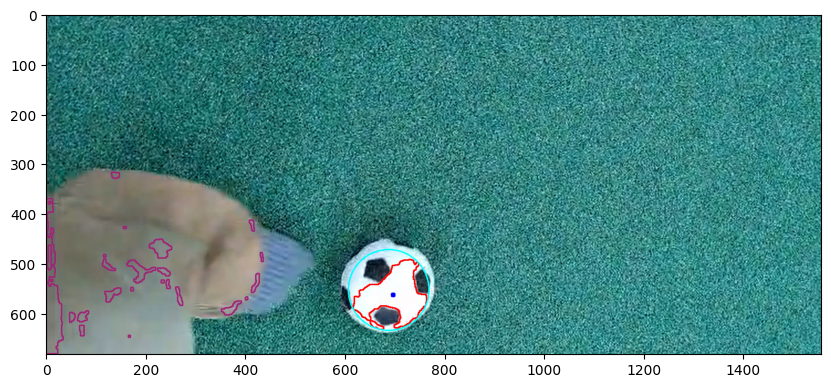

In [21]:
((x, y), radius) = cv2.minEnclosingCircle(best_circle)
M = cv2.moments(best_circle)
center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

# only proceed if the radius meets a minimum size
if radius > 10:
    # draw the circle and centroid on the frame,
    # then update the list of tracked points
    cv2.circle(frame, (int(x), int(y)), int(radius),
        (0, 255, 255), 2)
    cv2.circle(frame, center, 5, (0, 0, 255), -1)

visualize(frame)